In [74]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


### Base Input

In [75]:
df = pd.read_csv("bananaindex.csv")
food_names = df['entity']
df = pd.get_dummies(df, drop_first=True)

X = df[
    [
        "land_use_kg",
        "land_use_1000kcal",
        "Land use per 100 grams of protein",
        # "Land use per 100 grams of fat",
    ]
].values
y = df[
    [
        "Bananas index (kg)",
        "Bananas index (1000 kcalories)",
        "Bananas index (100g protein)",
    ]
].values

# Impute missing values and scale the features
imputer = SimpleImputer(strategy="mean")
scaler = StandardScaler()

X_imputed = imputer.fit_transform(X)
X_scaled = scaler.fit_transform(X_imputed)

# Divide dataset
X_train, X_test, y_train, y_test, names_train, names_test = train_test_split(
    X_scaled, y, food_names, test_size=0.2, random_state=42
)

In [76]:
def model_wrap(model_input):
    multi_output_model = MultiOutputRegressor(model_input)
    multi_output_model.fit(X_train, y_train)
    return multi_output_model.predict(X_test)

def evaluate(y_test, y_pred, model_name=None):
    # Evaluate the model
    for r in range(y_test.shape[1]):
        r2 = r2_score(y_test[:, r], y_pred[:, r])
        print(f'R-squared for the {r + 1} target: {r2}')

    plt.figure(figsize=(14, 4))

    for i in range(y_test.shape[1]):
        plt.subplot(1, y_test.shape[1], i+1)
        plt.scatter(y_test[:, i], y_pred[:, i], color='blue', label='Actual vs Predicted')
        plt.title(f'Target {i+1}')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')

        min_val = min(y_test[:, i].min(), y_pred[:, i].min())
        max_val = max(y_test[:, i].max(), y_pred[:, i].max())
        plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', lw=2)
        plt.legend()
        plt.grid(True)

    plt.tight_layout()

    # Set the overall title
    if model_name:
        plt.suptitle(f'Evaluation of {model_name}', fontsize=16, y=1.05)

    plt.show()

In [77]:
import ModelComparison
from importlib import reload

reload(ModelComparison)
model_output = ModelComparison.ModelComparison()

## Linear Regression

R-squared for the 1 target: 0.9562939950118975
R-squared for the 2 target: 0.8703743810047955
R-squared for the 3 target: 0.5889284791671455


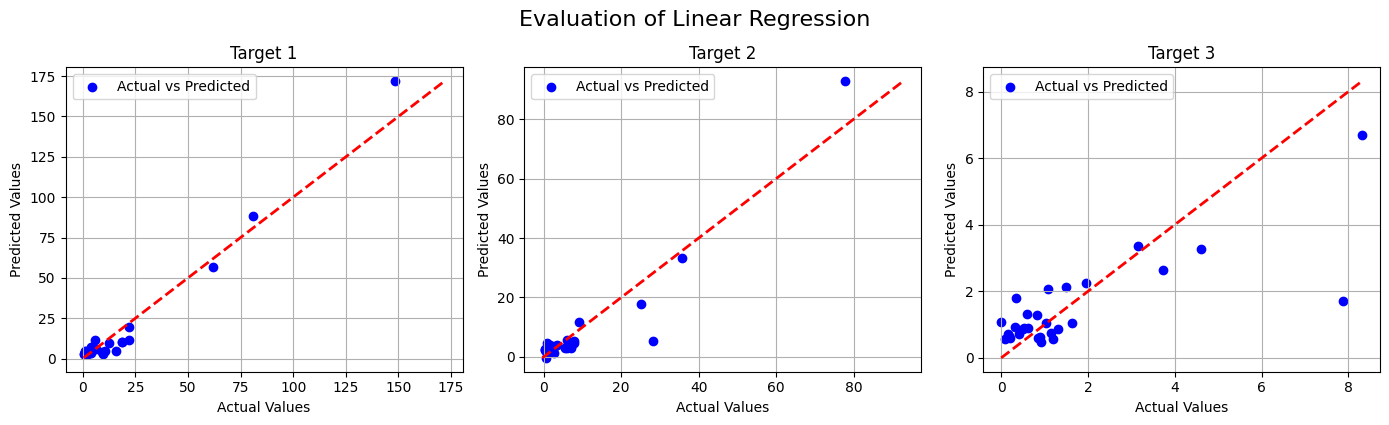

In [78]:
base_model = LinearRegression()
y_pred = model_wrap(base_model)
evaluate(y_test, y_pred, "Linear Regression")
model_output.add_model_results('Linear Regression', names_test, y_test, y_pred)

## Random Forest Regression Model

R-squared for the 1 target: 0.8035144522737878
R-squared for the 2 target: 0.7623468130491813
R-squared for the 3 target: 0.5997732737739653


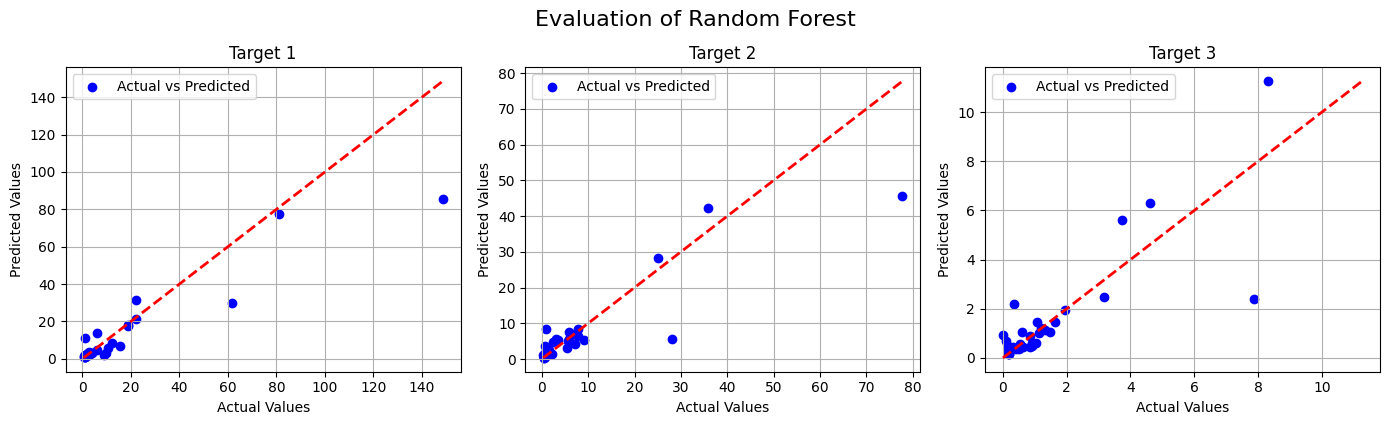

In [79]:
from sklearn.ensemble import RandomForestRegressor

# Initialize RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)
y_pred = model_wrap(rf_model)
evaluate(y_test, y_pred, 'Random Forest')
model_output.add_model_results('Random Forest', names_test, y_test, y_pred)

## Grid Search Model

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters from grid search:  {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 500}
R-squared for the 1 target: 0.7780485654633164
R-squared for the 2 target: 0.6683468579360282
R-squared for the 3 target: 0.6287126454686363


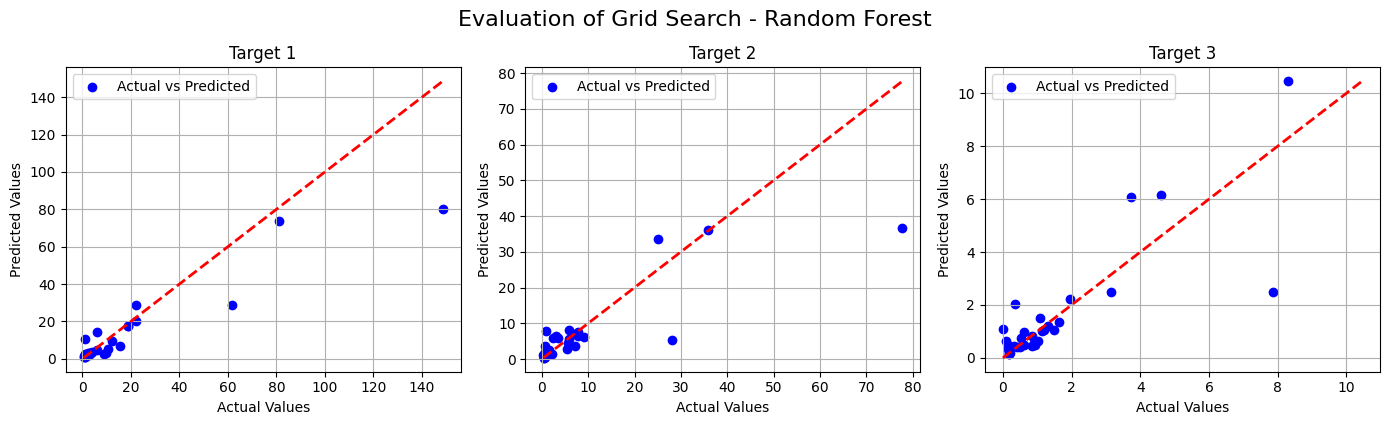

In [80]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for RandomForestRegressor
param_grid = {
    "n_estimators": [100, 200, 500],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
}

# Initialize the grid search model
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,  # Number of folds for cross-validation
    verbose=2,  # Controls the verbosity: the higher, the more messages
    n_jobs=-1,
)  # Number of jobs to run in parallel

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and associated model
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

print("Best parameters from grid search: ", best_params)

y_pred = model_wrap(best_rf_model)
evaluate(y_test, y_pred, 'Grid Search - Random Forest')
model_output.add_model_results('Grid Search - Random Forest', names_test, y_test, y_pred)

## Pipe Line 

R-squared for the 1 target: 0.7780485654633164
R-squared for the 2 target: 0.6683468579360282
R-squared for the 3 target: 0.6287126454686363


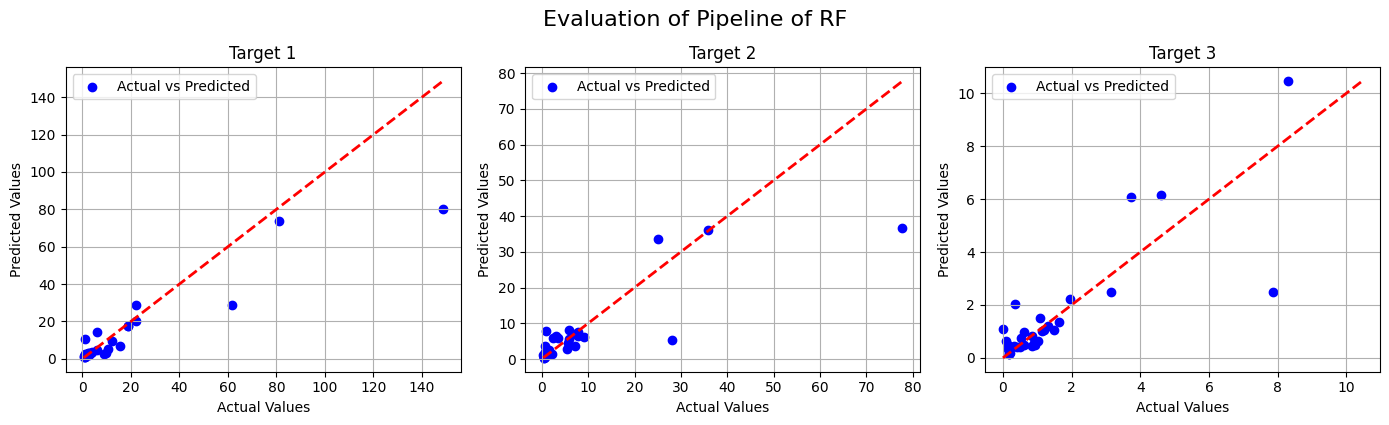

In [81]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# A pipeline with StandardScaler and the best RandomForestRegressor
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(**best_params, random_state=42))  # Using best_params found from grid search
])

y_pred = model_wrap(pipeline)
evaluate(y_test, y_pred, 'Pipeline of RF')
model_output.add_model_results('Pipeline of RF', names_test, y_test, y_pred)

### Neural Network

Epoch 1/50
4/4 [==============================] - 1s 34ms/step - loss: 82.9982 - val_loss: 107.9826
Epoch 2/50
4/4 [==============================] - 0s 9ms/step - loss: 82.7177 - val_loss: 107.4692
Epoch 3/50
4/4 [==============================] - 0s 8ms/step - loss: 82.3072 - val_loss: 107.0014
Epoch 4/50
4/4 [==============================] - 0s 10ms/step - loss: 80.4542 - val_loss: 106.5397
Epoch 5/50
4/4 [==============================] - 0s 9ms/step - loss: 79.7624 - val_loss: 106.0250
Epoch 6/50
4/4 [==============================] - 0s 9ms/step - loss: 81.0133 - val_loss: 105.4543
Epoch 7/50
4/4 [==============================] - 0s 8ms/step - loss: 79.9524 - val_loss: 104.8516
Epoch 8/50
4/4 [==============================] - 0s 10ms/step - loss: 77.9143 - val_loss: 104.1637
Epoch 9/50
4/4 [==============================] - 0s 9ms/step - loss: 78.3906 - val_loss: 103.3261
Epoch 10/50
4/4 [==============================] - 0s 9ms/step - loss: 74.4539 - val_loss: 102.4207
Epoch 

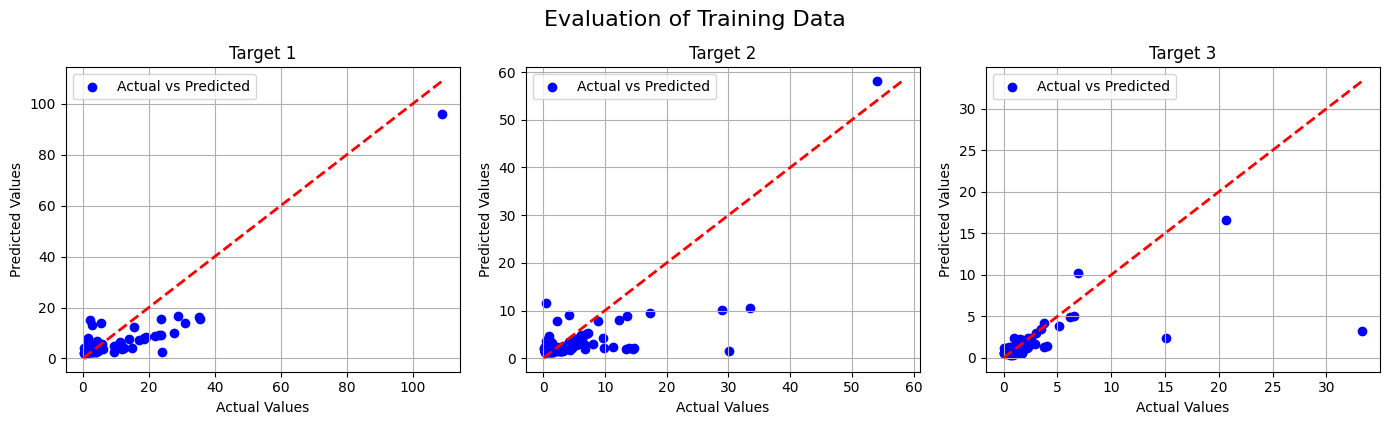

R-squared for the 1 target: 0.946649190276153
R-squared for the 2 target: 0.8800307353403191
R-squared for the 3 target: 0.32497360611349047


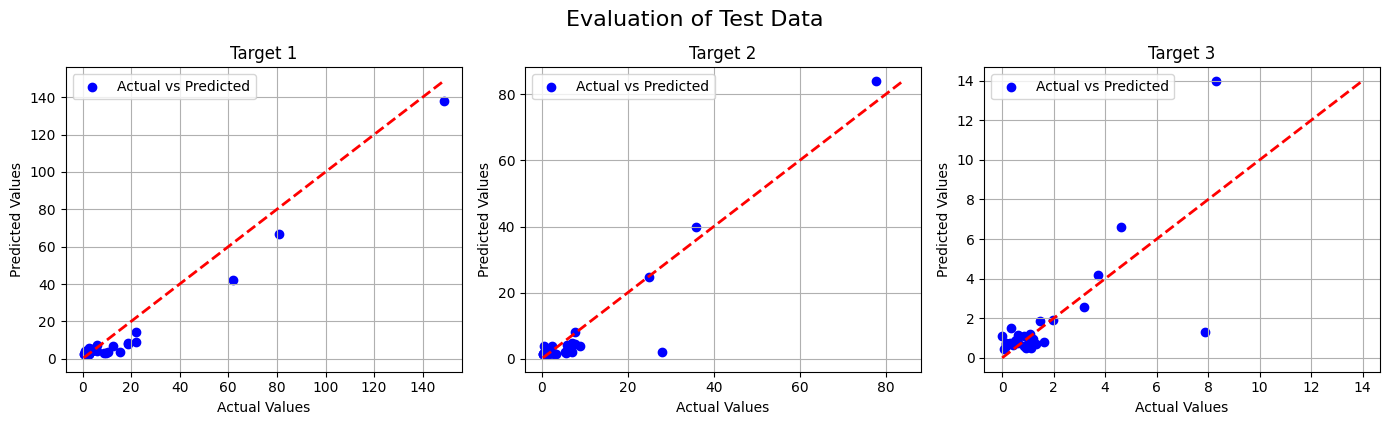

In [82]:
import tensorflow as tf

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Model definition
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1]))  # No activation for a regression problem

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with a validation split
history = model.fit(
    X_train, y_train,
    epochs=50,  # More epochs with early stopping
    batch_size=32,
    validation_split=0.2,  # Use part of the training data for validation
    callbacks=[early_stopping]
)

# Predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate
evaluate(y_train, y_pred_train, 'Training Data')
evaluate(y_test, y_pred_test, 'Test Data')
model_output.add_model_results('Neural Network', names_test, y_test, y_pred_test)

### Bayesian Optimized NN

In [84]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import load_model
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import joblib

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

space = {
    'units1': hp.choice('units1', [32, 64, 128, 256]),
    'dropout1': hp.uniform('dropout1', 0, 0.5),
    'units2': hp.choice('units2', [32, 64, 128]),
    'dropout2': hp.uniform('dropout2', 0, 0.5),
    'batch_size': hp.choice('batch_size', [16, 32, 64]),
    'optimizer': hp.choice('optimizer', ['adam', 'rmsprop'])
}

def build_model(units1, dropout1, units2, dropout2, optimizer):
    model = tf.keras.models.Sequential([
        Dense(units1, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dropout(dropout1),
        Dense(units2, activation='relu'),
        Dropout(dropout2),
        Dense(y_train.shape[1])  # Output layer with no activation for regression
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Define the objective function for hyperopt
def objective(hyperparams):
    # Extract batch_size and remove from hyperparams as it's not needed for build_model
    batch_size = hyperparams.pop('batch_size')
    model = build_model(**hyperparams)
    model.fit(X_train_scaled, y_train, batch_size=batch_size, epochs=100, verbose=0)
    
    # Add batch_size back to hyperparams for any further use
    hyperparams['batch_size'] = batch_size
    
    y_pred_test = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred_test)
    return {'loss': mse, 'status': STATUS_OK}

# Run the hyperparameter optimization
trials = Trials()
best_hyperparams = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

# Correctly extract the best hyperparameters, including batch_size
best_units1 = [32, 64, 128, 256][best_hyperparams['units1']]
best_dropout1 = best_hyperparams['dropout1']
best_units2 = [32, 64, 128][best_hyperparams['units2']]
best_dropout2 = best_hyperparams['dropout2']
best_batch_size = [16, 32, 64][best_hyperparams['batch_size']]
best_optimizer = ['adam', 'rmsprop'][best_hyperparams['optimizer']]

# Re-train the model with the best hyperparameters
best_model = build_model(best_units1, best_dropout1, best_units2, best_dropout2, best_optimizer)
best_model.fit(X_train_scaled, y_train, batch_size=best_batch_size, epochs=100, verbose=0)

# Predict with the best model
y_pred_test = best_model.predict(X_test_scaled)

# Evaluate the best model
evaluate(y_test, y_pred_test, model_name="Best Model")
model_output.add_model_results('Optimized Neural Network', names_test, y_test, y_pred_test)


1/1 [==============================] - 0s 48ms/step  

1/1 [==============================] - 0s 44ms/step                            

1/1 [==============================] - 0s 44ms/step                            

1/1 [==============================] - 0s 41ms/step                            

1/1 [==============================] - 0s 49ms/step                            

1/1 [==============================] - 0s 42ms/step                            

1/1 [==============================] - 0s 44ms/step                            

1/1 [==============================] - 0s 47ms/step                            

1/1 [==============================] - 0s 44ms/step                            

1/1 [==============================] - 0s 42ms/step                            

1/1 [==============================] - 0s 42ms/step                             

1/1 [==============================] - 0s 41ms/step                             

1/1 [==============================] - 0s 43ms/step 

IndexError: list index out of range

In [ ]:
model_output.export_to_excel('./IndexResults.xlsx')

d:\GitHub\BananaIndex\my_jupyter_venv\Lib\site-packages\openpyxl\workbook\child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


## Feature Importance Visualization for RandomForestRegressor

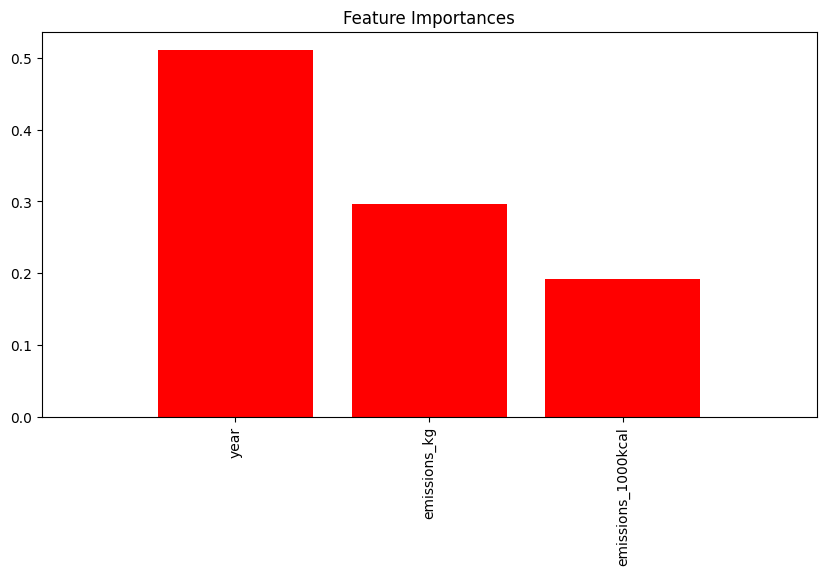

In [ ]:
# Feature importance for RandomForestRegressor
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = df.columns[:len(importances)]

plt.figure(figsize=(10, 5))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

## Visualizing GridSearchCV Results

In [ ]:
import seaborn as sns

# Heatmap for GridSearchCV results
results = pd.DataFrame(grid_search.cv_results_)
pivot_table = results.pivot_table(index='param_n_estimators',
                                  columns='param_max_depth',
                                  values='mean_test_score')
sns.heatmap(pivot_table, annot=True, cmap='viridis', fmt=".3f")
plt.title("Grid Search R-squared Scores")
plt.xlabel("Max Depth")
plt.ylabel("Number of Estimators")
plt.show()

ModuleNotFoundError: No module named 'seaborn'

## Residual Plot for LinearRegression

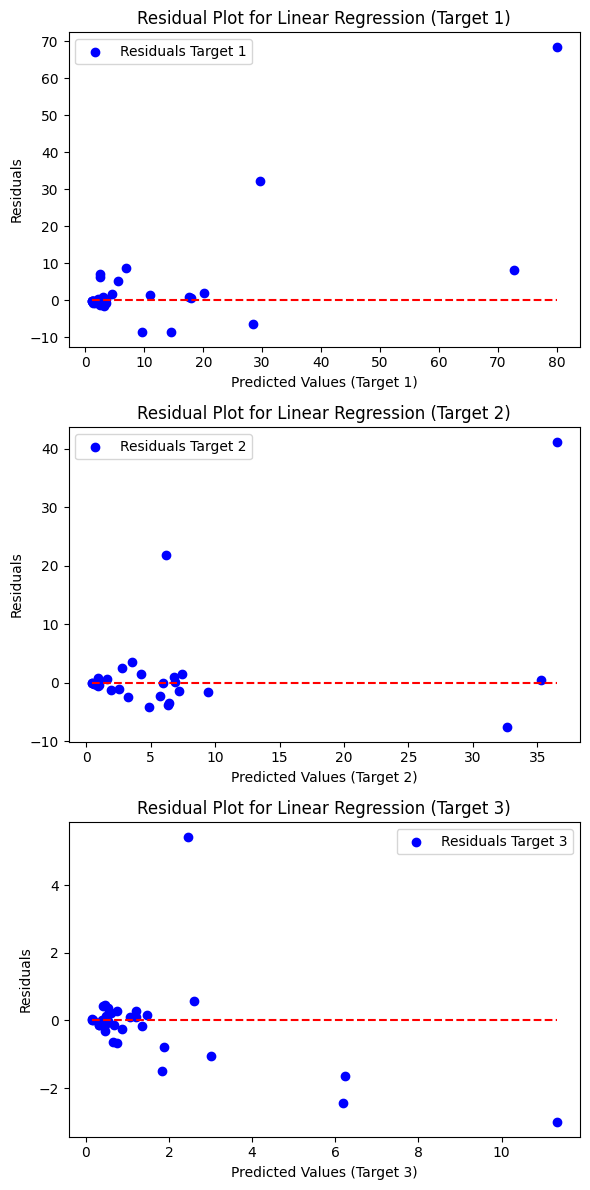

In [ ]:
# Number of targets
n_targets = y_test.shape[1]

# Create a figure with a subplot for each target
fig, axes = plt.subplots(n_targets, 1, figsize=(6, 4 * n_targets))

# Loop through each target for residual plots
for i in range(n_targets):
    residuals = y_test[:, i] - y_pred[:, i]
    axis = axes[i] if n_targets > 1 else axes
    axis.scatter(y_pred[:, i], residuals, color='blue', label=f'Residuals Target {i+1}')
    axis.hlines(0, np.min(y_pred[:, i]), np.max(y_pred[:, i]), colors='red', linestyles='--')
    axis.set_xlabel(f'Predicted Values (Target {i+1})')
    axis.set_ylabel('Residuals')
    axis.set_title(f'Residual Plot for Linear Regression (Target {i+1})')
    axis.legend()

plt.tight_layout()
plt.show()

## Actual vs Predicted values

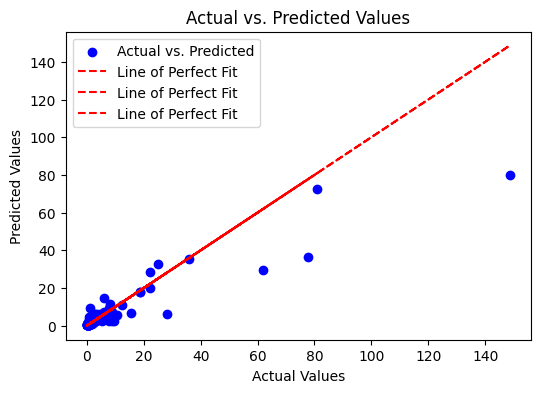

In [ ]:
# Actual vs Predicted scatter plot
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred, color='blue', label='Actual vs. Predicted')
plt.plot(y_test, y_test, color='red', label='Line of Perfect Fit', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

## Nutritional Footprint Index

              entity         NFI
109           Onions  414.822469
148            Sugar  168.440645
4        Apple juice  165.729887
52      Coconut milk  131.371548
6             Apples  116.461309
110     Orange juice   93.798215
92             Limes   89.956403
89            Lemons   88.877083
111          Oranges   88.419077
154         Tomatoes   79.611802
118            Pears   73.754729
39   Cherry tomatoes   69.444597
95         Marmalade   68.307804
122        Pineapple   62.207183
107         Oat milk   57.824733
80            Grapes   50.917561
99             Melon   49.999833
153   Tomato ketchup   49.617278
158       Watermelon   44.281558
29           Cabbage   43.801797
136      Raspberries   41.167163
129         Potatoes   39.171737
64          Cucumber   38.421500
35       Cauliflower   38.049165
53       Coconut oil   34.594921
85             Kiwis   34.411288
27          Broccoli   29.809527
84              Kale   27.948190
33           Carrots   27.692691
121       

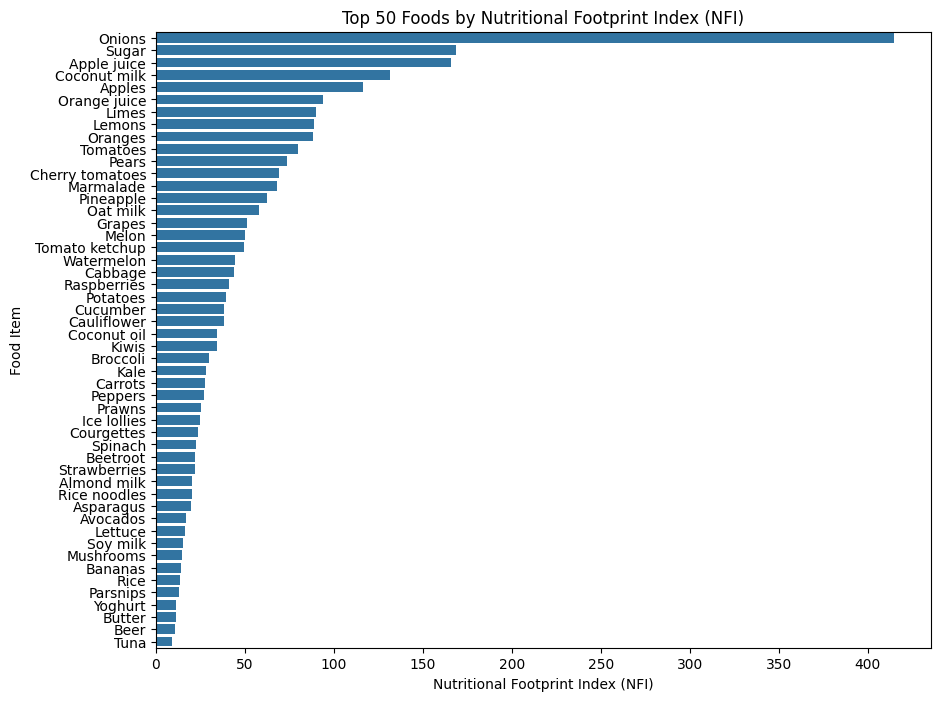

In [ ]:
# Utility function to extract original 'entity' name from one-hot encoded columns
def retrieve_entity_name(df, prefix='entity_'):
    df['entity'] = df.filter(regex=f'^{prefix}').idxmax(axis=1)
    df['entity'] = df['entity'].str.replace(prefix, '')
    return df

# Function to compute Nutritional Footprint Index (NFI)
def calculate_nfi(df):
    env_cost = (df['emissions_kg'] + df['land_use_kg']) / 2
    nutritional_value = (df['emissions_1000kcal'] + df['emissions_100g_protein'] + df['emissions_100g_fat']) / 3
    normalized_env_cost = (env_cost - env_cost.min()) / (env_cost.max() - env_cost.min())
    normalized_nutri_value = (nutritional_value - nutritional_value.min()) / (nutritional_value.max() - nutritional_value.min())
    df['NFI'] = normalized_nutri_value / (normalized_env_cost + 0.0001)  # Avoid division by zero
    return df

# Sort dataframe based on NFI and display the top 50 food items
def display_top_nfi(df, top_n=50):
    df_sorted = df.sort_values(by='NFI', ascending=False)
    print(df_sorted[['entity', 'NFI']].head(top_n))

# Visualize the top N items based on NFI
def visualize_top_nfi(df, top_n=50):
    df_sorted = df.sort_values(by='NFI', ascending=False).head(top_n)
    plt.figure(figsize=(10, 8))
    sns.barplot(data=df_sorted, x='NFI', y='entity')
    plt.title('Top 50 Foods by Nutritional Footprint Index (NFI)')
    plt.xlabel('Nutritional Footprint Index (NFI)')
    plt.ylabel('Food Item')
    plt.show()

# Running the functions on the DataFrame
df = retrieve_entity_name(df)
df = calculate_nfi(df)
display_top_nfi(df)
visualize_top_nfi(df)

   - A higher NFI value indicates that the food item provides more nutrition per environmental cost unit. In other words, it's a more 'eco-efficient' or 'sustainable' choice from the viewpoint of emissions and land use for the nutritional content it provides.
   - The NFI is attempting to encapsulate the trade-off between the environmental impact of producing the food and the nutritional benefits it offers. 

In [ ]:
# Creating a mock DataFrame for three new food items
# The features used here must match the ones used in training your model
# As an example, let's assume your model was trained on the following features: 
# 'emissions_kg', 'emissions_1000kcal', 'emissions_100g_protein', 'emissions_100g_fat', 
# 'land_use_kg', 'land_use_1000kcal', 'Land use per 100 grams of protein', 
# 'Land use per 100 grams of fat'

new_data = pd.DataFrame({
    'emissions_kg': np.random.uniform(0.1, 1, 3),
    'emissions_1000kcal': np.random.uniform(0.1, 2, 3),
    'emissions_100g_protein': np.random.uniform(0.1, 10, 3),
    'emissions_100g_fat': np.random.uniform(0.1, 5, 3),
    'land_use_kg': np.random.uniform(0.1, 10, 3),
    'land_use_1000kcal': np.random.uniform(0.1, 5, 3),
    'Land use per 100 grams of protein': np.random.uniform(0.1, 10, 3),
    'Land use per 100 grams of fat': np.random.uniform(0.1, 15, 3)
}, index=['NewFood1', 'NewFood2', 'NewFood3']) 

# Add a mock 'entity' column to identify each item
new_data['entity'] = new_data.index

# Display the mock new data
print(new_data)

          emissions_kg  emissions_1000kcal  emissions_100g_protein  \
NewFood1      0.506735            1.673829                0.679480   
NewFood2      0.409344            1.634802                5.078642   
NewFood3      0.698830            0.961295                2.458124   

          emissions_100g_fat  land_use_kg  land_use_1000kcal  \
NewFood1            4.638727     6.358020           1.652126   
NewFood2            1.725926     4.540026           2.544803   
NewFood3            3.461322     9.861558           2.997777   

          Land use per 100 grams of protein  Land use per 100 grams of fat  \
NewFood1                           0.326618                       2.241257   
NewFood2                           1.345661                       9.655319   
NewFood3                           0.312771                       1.181715   

            entity  
NewFood1  NewFood1  
NewFood2  NewFood2  
NewFood3  NewFood3  


In [ ]:
import pandas as pd
from tensorflow.keras.models import load_model
import joblib

# Load the trained model and scaler
model = load_model('NFI_Predictor_Model.h5')
scaler = joblib.load('NFI_Predictor_Scaler.gz')

# Original features used for scaling during model training:
training_features = ['emissions_kg', 'land_use_kg', 'emissions_1000kcal', 'emissions_100g_protein']

# Create mock data for three new items, ensuring the same features as during the model training
new_data = pd.DataFrame({
    'emissions_kg': [0.5, 0.3, 0.7],
    'land_use_kg': [7.4, 2.5, 3.2],
    'emissions_1000kcal': [0.8, 0.6, 1.0],
    'emissions_100g_protein': [4.1, 2.9, 5.7]
}, index=['NewFood1', 'NewFood2', 'NewFood3'])

# Assuming the 'entity' are the names of the new food items
food_item_names = new_data.index.tolist()

# Scale ONLY the numeric features (same as the ones used during training)
new_data_scaled = scaler.transform(new_data[training_features])

# Predict with the model
nfi_predictions = model.predict(new_data_scaled)

# Check the prediction shape and adjust as necessary
print("Prediction shape:", nfi_predictions.shape)
if nfi_predictions.shape[1] != 1:
    raise ValueError("Model is outputting multiple values per sample, expected a single value.")

# Assuming we only care about the first prediction
nfi_predictions = nfi_predictions[:, 0]  # Take the first column of predictions

# Ensure there's one prediction per input sample
if len(nfi_predictions) != len(food_item_names):
    raise ValueError("Number of predictions does not match number of samples in new data.")

# Add the predictions to the result DataFrame
result_df = pd.DataFrame({
    'entity': food_item_names,
    'Predicted_NFI': nfi_predictions
})

# Display the new DataFrame with entities and their associated predicted NFI scores
print(result_df)

1/1 [==============================] - 0s 33ms/step
Prediction shape: (3, 3)


c:\Users\Administrator\anaconda3\envs\new_env_name\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


ValueError: Model is outputting multiple values per sample, expected a single value.